In [ ]:
import time
import numpy as np
import pyscf

def restricted_HF_convE_and_DM(mol, conv_tol = 1e-10):
    """Restricted Hartree-Fock method, following Szabo and Ostlund.
    """
    start = time.time()

    n_a = mol.nelec[0]

    T = mol.intor("int1e_kin")
    Vnuc = mol.intor("int1e_nuc")
    hcore = T + Vnuc
    S = mol.intor("int1e_ovlp")
    h2e = mol.intor('int2e', aosym="s1") # most expensive, least intelligent way of doing this.

    convE = 10
    convDM = 10
    convComm = 10

    # we now implement checking convergence of both density matrix as well as energy.

    s, U = np.linalg.eigh(S)
    
    s_inv_sqrt = np.diag([x**(-0.5) for x in s])

    X = U @ s_inv_sqrt @ U.conj().T

    F0 = X.T @ hcore @ X
    _, C0 = np.linalg.eigh(F0)
    C = X @ C0
    P = 2 * C[:, :n_a] @ C[:, :n_a].T

    Eprev = None

    while convE > conv_tol or convDM > conv_tol or convComm > conv_tol:
        
        G = np.einsum('ij,klji->kl',P,h2e) - 0.5 * np.einsum('ij,kijl->kl',P,h2e)
        F = hcore + G

        E0 = 0.5 * np.einsum('ij,ij->',P,hcore+F)

        if Eprev is not None:
            convE = np.abs(E0 - Eprev)

        convComm = np.linalg.norm(F @ P @ S - S @ P @ F, 'fro')

        if convE < conv_tol and convDM < conv_tol and convComm < conv_tol:
            break
        
        Eprev = E0

        Fp = X.conj().T @ F @ X
        eps, Cp = np.linalg.eigh(Fp)
        C = X @ Cp

        Pnew = 2 * C[:,0:n_a] @ C[:,0:n_a].conj().T
        convDM = np.linalg.norm(Pnew-P)
        P = Pnew

    E0 = E0 + mol.energy_nuc()

    end = time.time()
    print(f"Converged in {end - start} seconds")

    return E0, P, F, C


In [ ]:
def ccsd(mol, reference, norb, nelec):
    T = mol.intor("int1e_kin")
    Vnuc = mol.intor("int1e_nuc")
    hcore = T + Vnuc

    # assume restricted HF reference

    nalpha = nelec//2
    nbeta = nelec-nalpha

    E0 = reference[0]
    Pref = reference[1]
    Fock = reference[2]
    C = reference[3]

    orbital_energies = np.diag(C.T @ Fock @ C)

    occupied = C[:,:nalpha]
    unoccupied = C[:,nalpha:]

    

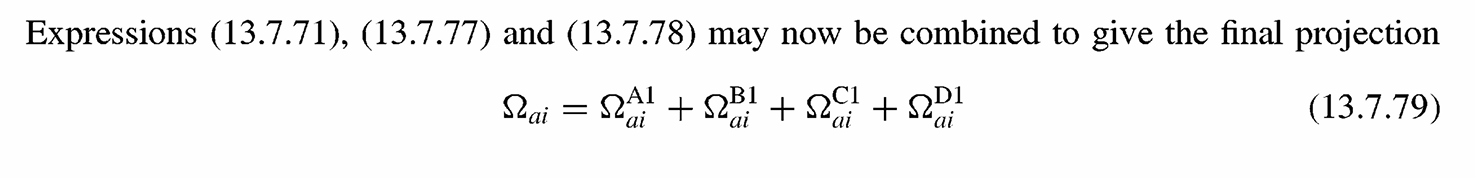
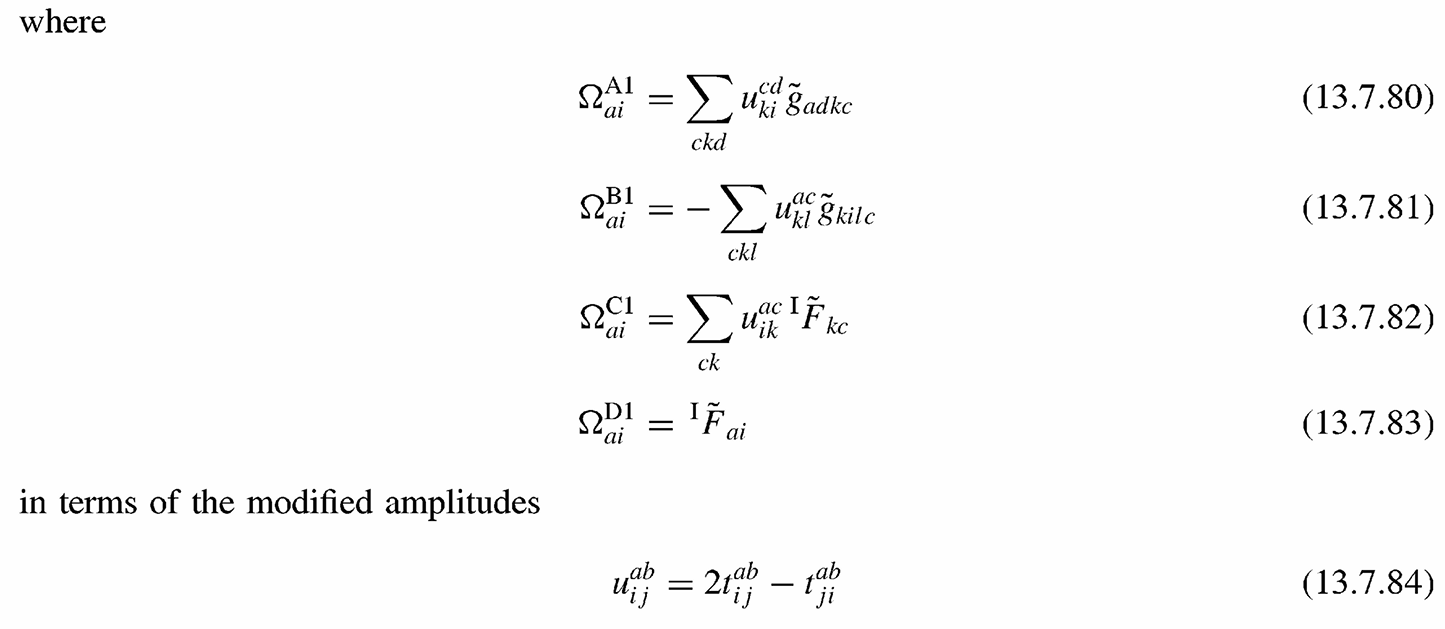



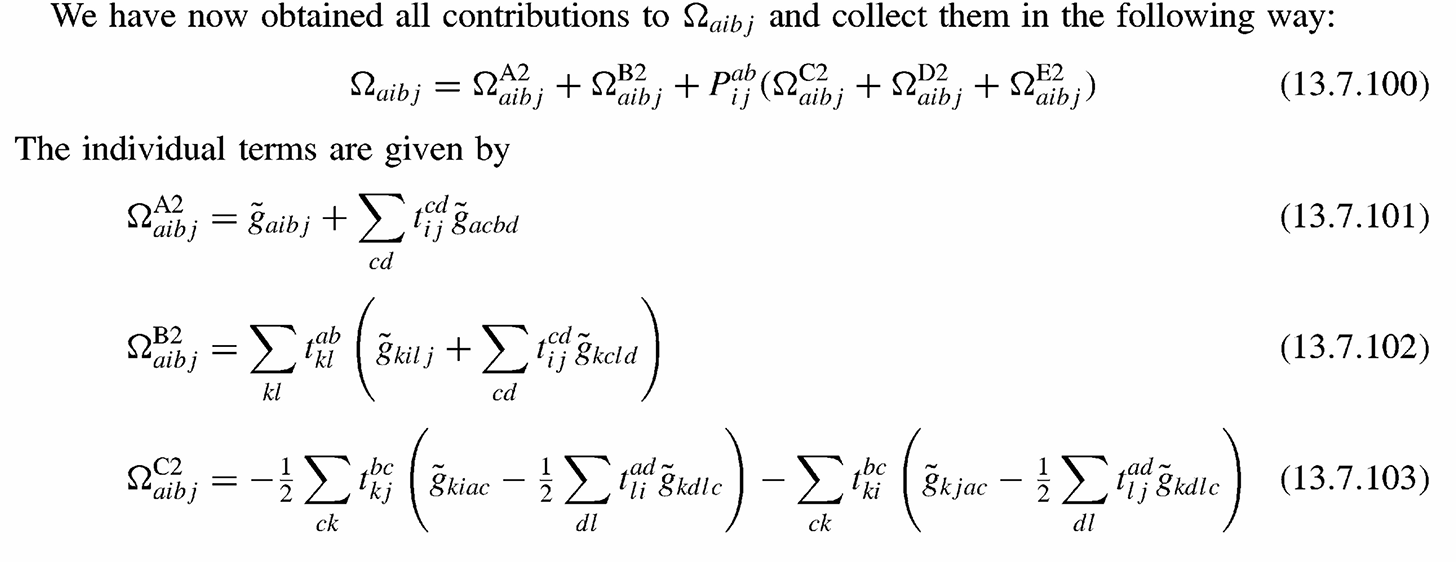
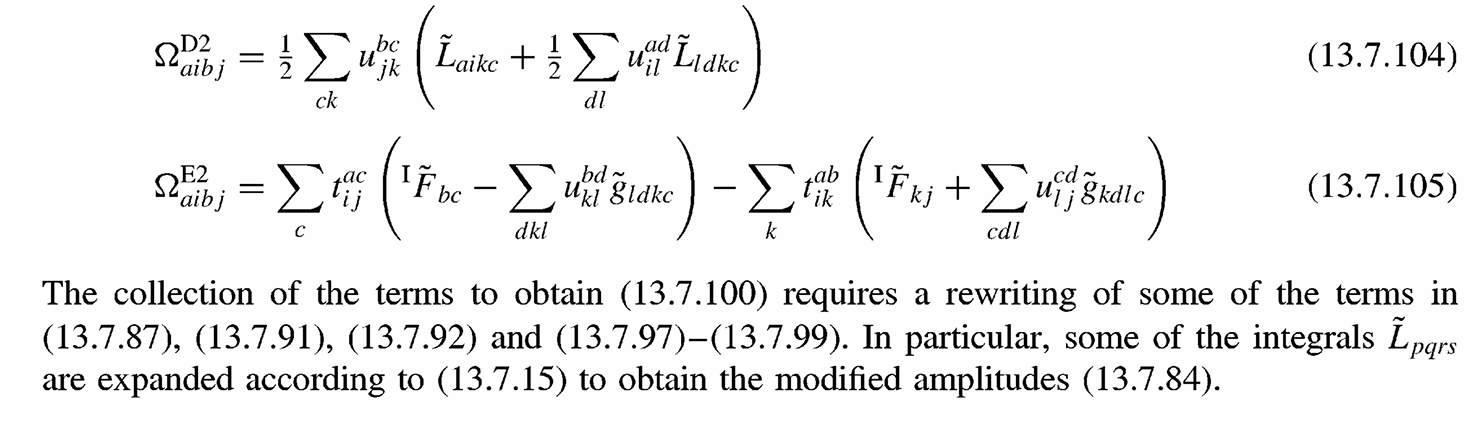

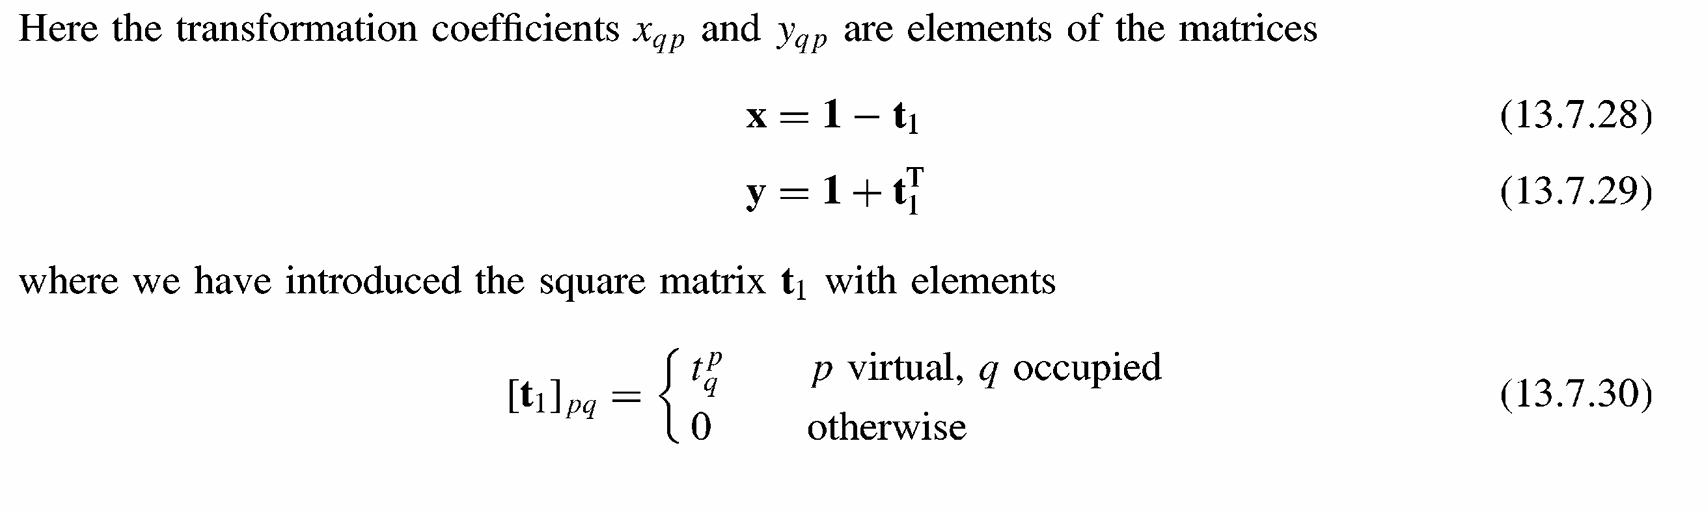
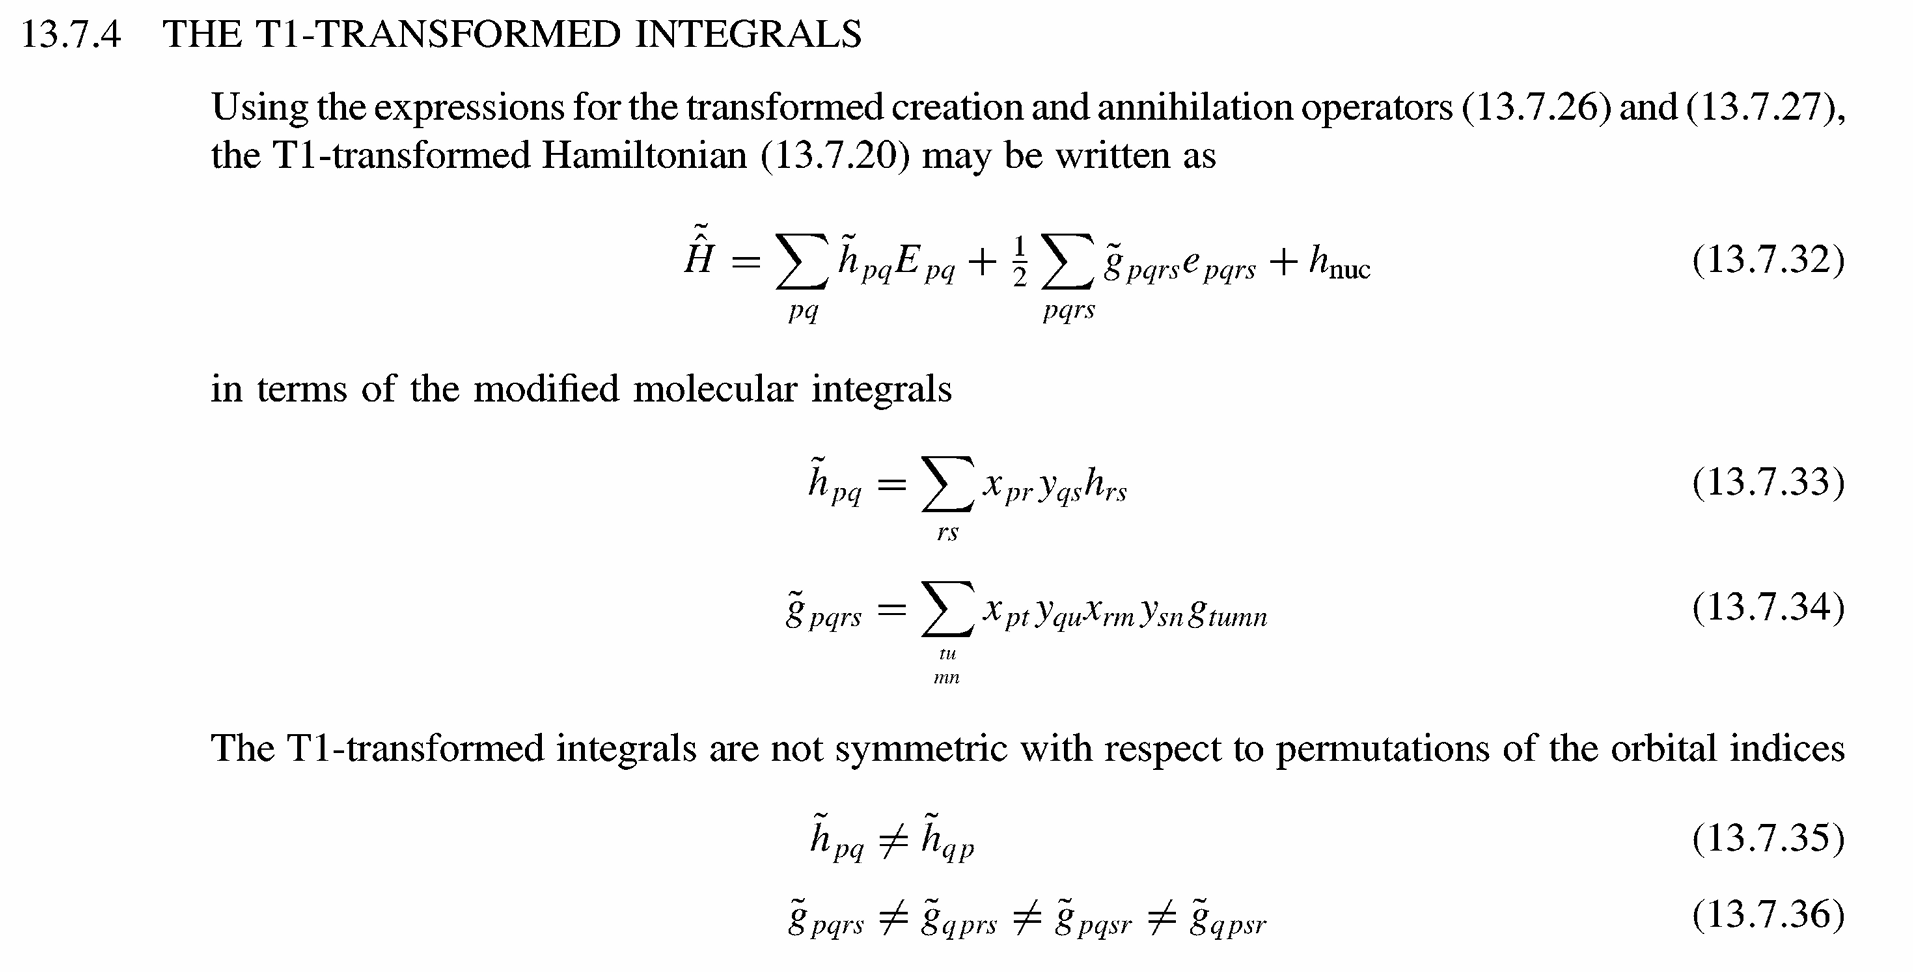